In [14]:
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import copy
import pandas as pd
import xarray as xr
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

In [15]:
case = "fanv3_improving"
path = "/glade/scratch/jinmuluo/archive/CanopyReduction/lnd/hist/" 

start_date = date(2015, 1, 1)
end_date = date(2015, 12, 1)
delta = end_date - start_date

Vars = ['MANURE_N_GRZ', 'MANURE_N_BARNS', 'FERT_N_APP', 'NDEP_TO_SMINN', 'NFIX_TO_SMINN', 
        'FFIX_TO_SMINN', 'FERT_TO_SMINN', 'NITRATE_N_TO_SMINN', 'F_CANOPY_TO_SOIL',
        'NH3_TOTAL', 'NH3_MANURE_APP', 'NH3_GRZ', 'NH3_BARNS', 'NH3_STORES', 'NH3_FERT', 
        'NOx_NITRIFY_TOTAL', 'N2O_NITRIFY_TOTAL', 'NOx_DENITRIFY_TOTAL', 'N2O_DENITRIFY_TOTAL', 
        'NOx_TOTAL', 'N2O_TOTAL', 'N2_TOTAL', 
        'MANURE_N_TO_SMINN', 'SYNTHFERT_N_TO_SMINN', 
        'CANOPY_TO_SOIL', 'MANURE_NITRATE_TO_SOIL', 'FERT_NITRATE_TO_SOIL', 
        'MANURE_NH4_RUNOFF', 'FERT_NH4_RUNOFF', 'MANURE_NITRATE_RUNOFF', 'FERT_NITRATE_RUNOFF',
        'F_N2O_NIT', 'F_NOx_NIT', 'F_N2O_DENIT', 'F_NOx_DENIT', 'F_N2_DENIT', 
        'SMIN_NO3_RUNOFF', 'SMIN_NO3_LEACHED', 'area', 'landfrac']


In [16]:
fanCLM = []
for i in range(delta.days//30 + 1):
    month = start_date + relativedelta(months=i)
    month = month.strftime('%Y-%m')
    fanCLM.append(path + case + ".clm2.h0" + "." + month +".nc")

def preprocess(ds, fields = Vars):
    return(ds[fields])

def fix_time(ds):  
    date0 = ds['time'][0].values
    date1 = ds['time'][-1].values
    # ds['time'] =xr.cftime_range(str(yr0),periods=ndays,freq='D')
    ds['time'] = pd.date_range(str(date0),str(date1),freq='MS') 
    
    return ds

dsCLM = fix_time(xr.open_mfdataset(fanCLM, decode_times=True, preprocess=preprocess))
dsCLM

<xarray.Dataset>
Dimensions:                 (time: 12, lat: 96, lon: 144)
Coordinates:
  * time                    (time) datetime64[ns] 2015-02-01 ... 2016-01-01
  * lon                     (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                     (lat) float32 -90.0 -88.11 -86.21 ... 88.11 90.0
Data variables: (12/40)
    MANURE_N_GRZ            (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    MANURE_N_BARNS          (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    FERT_N_APP              (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    NDEP_TO_SMINN           (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    NFIX_TO_SMINN           (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    FFIX_TO_SMINN           (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    ...                      ...
    F_NOx_DENIT             (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    F_N2_DENIT              (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    SMIN_NO3_RUNOFF         (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    SMIN_NO3_LEACHED        (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    area                    (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    landfrac                (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
Attributes: (12/101)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 05/22/23 21:43:43
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./fanv3_improving.clm2.h0.2000-01.nc
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

In [17]:
def map_function(da, cb=0, cmap='viridis', panel=None,  ax=None, title=None, vmax=None, vmin=None, units=None,nbins=200):
    "a function to make one subplot"
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()

    # define the colormap, including the number of bins
    cmap = copy.copy(plt.get_cmap(cmap,nbins))
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,transform=ccrs.PlateCarree(), vmax=vmax,vmin=vmin,cmap=cmap)

    # set the bounds of your plot
    ax.set_extent([-180,180,-90,90], crs=ccrs.PlateCarree())

    # add title & panel labels
    ax.set_title(title,loc='left', fontsize='large', fontweight='bold')
    ax.annotate(panel, xy=(0.05, 0.90), xycoords=ax.transAxes, ha='center', va='center',fontsize=16)    

    # add plotting features
    ax.coastlines()
    ocean = ax.add_feature(cfeature.NaturalEarthFeature('physical','ocean','110m', facecolor='white'))
    
    # control colorbars on each plot & their location
    if cb == 1:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.03, orientation='horizontal')
        cbar.set_label(units,size=12,fontweight='bold')
    if cb == 2:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.05, orientation='vertical')    
        cbar.set_label(units,size=12)#,weight='bold')
        

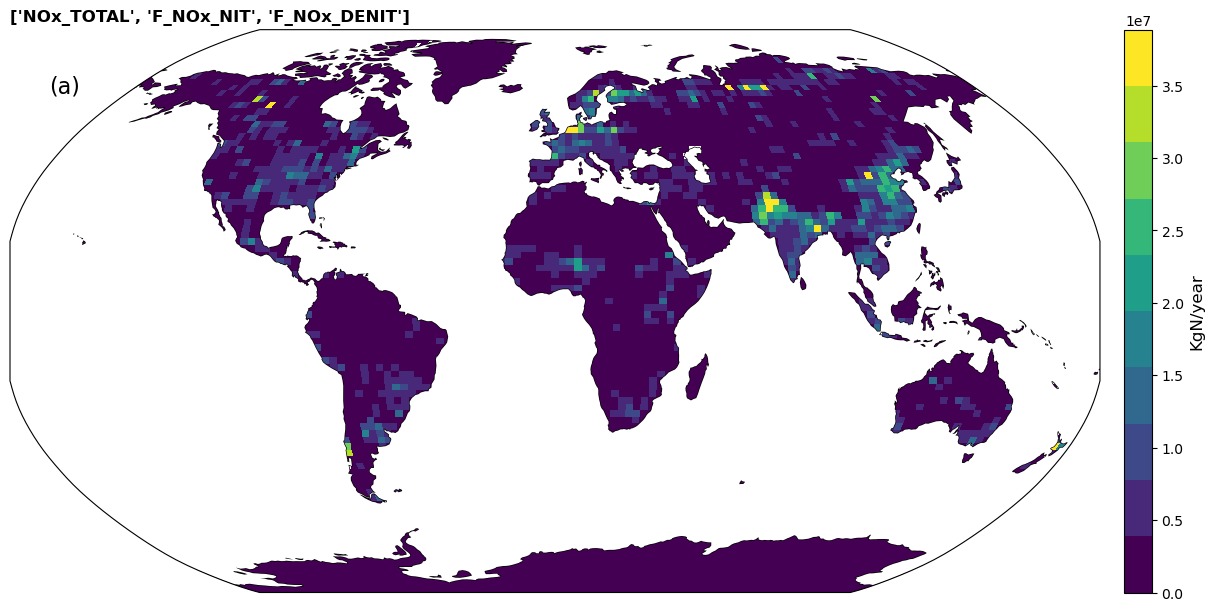

In [52]:
var=["NOx_TOTAL", "F_NOx_NIT", "F_NOx_DENIT"]

if len(var) >1:
    for i, v in enumerate(var):
        if i == 0:
            plotData = dsCLM[v]
        else:
            plotData = plotData + dsCLM[v]
else:
    plotData = dsCLM[var[0]]
    
i = 0
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,6), constrained_layout=True, subplot_kw=dict(projection=ccrs.Robinson()))
for index, ax in np.ndenumerate(axes):
    if i == 0:
        plotData = plotData.mean(dim='time')
        plotData = plotData * dsCLM['area'].isel(time=0) *1e6* dsCLM['landfrac'].isel(time=0) * 365 * 24 * 3600 * 1e-3
        plotData.attrs['units'] = 'KgN/year'
        map_function(plotData, ax=ax, cb=2, panel='(a)', vmax=plotData.max(skipna=True).values * 0.5, 
                     title=var, vmin=0.0, nbins=10, units=plotData.attrs['units'])                  
    i = i+1

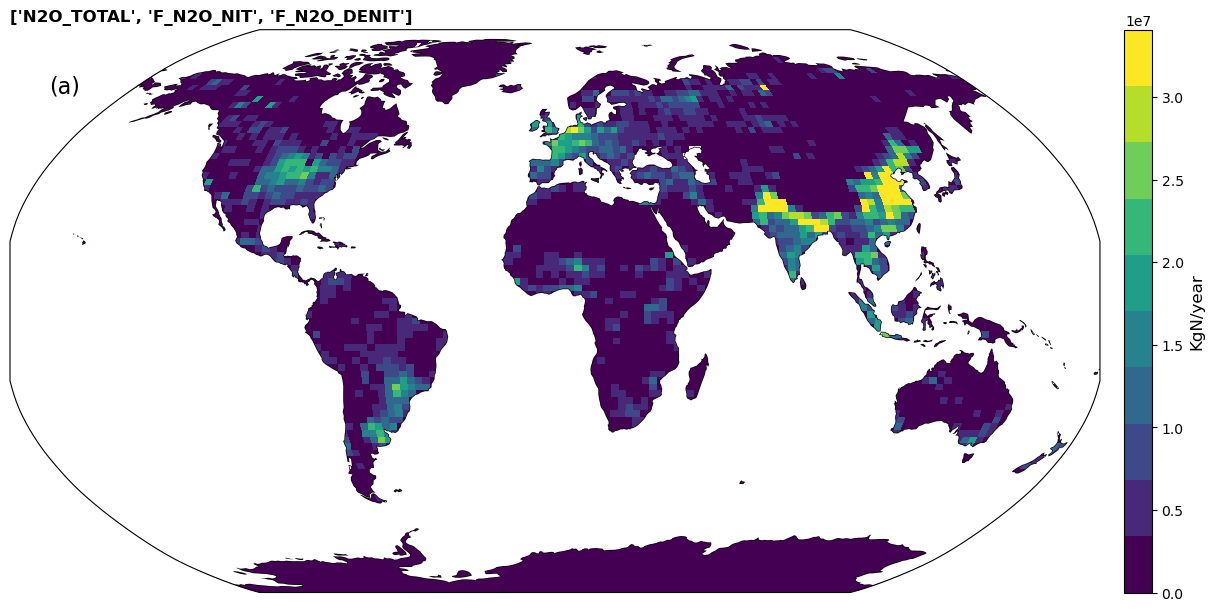

In [50]:
var=["N2O_TOTAL","F_N2O_NIT", "F_N2O_DENIT"]

if len(var) >1:
    for i, v in enumerate(var):
        if i == 0:
            plotData = dsCLM[v]
        else:
            plotData = plotData + dsCLM[v]
else:
    plotData = dsCLM[var[0]]
    
i = 0
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,6), constrained_layout=True, subplot_kw=dict(projection=ccrs.Robinson()))
for index, ax in np.ndenumerate(axes):
    if i == 0:
        plotData = plotData.mean(dim='time')
        plotData = plotData * dsCLM['area'].isel(time=0) *1e6* dsCLM['landfrac'].isel(time=0) * 365 * 24 * 3600 * 1e-3
        plotData.attrs['units'] = 'KgN/year'
        map_function(plotData, ax=ax, cb=2, panel='(a)', vmax=plotData.max(skipna=True).values * 0.5, 
                     title=var, vmin=0.0, nbins=10, units=plotData.attrs['units'])                  
    i = i+1

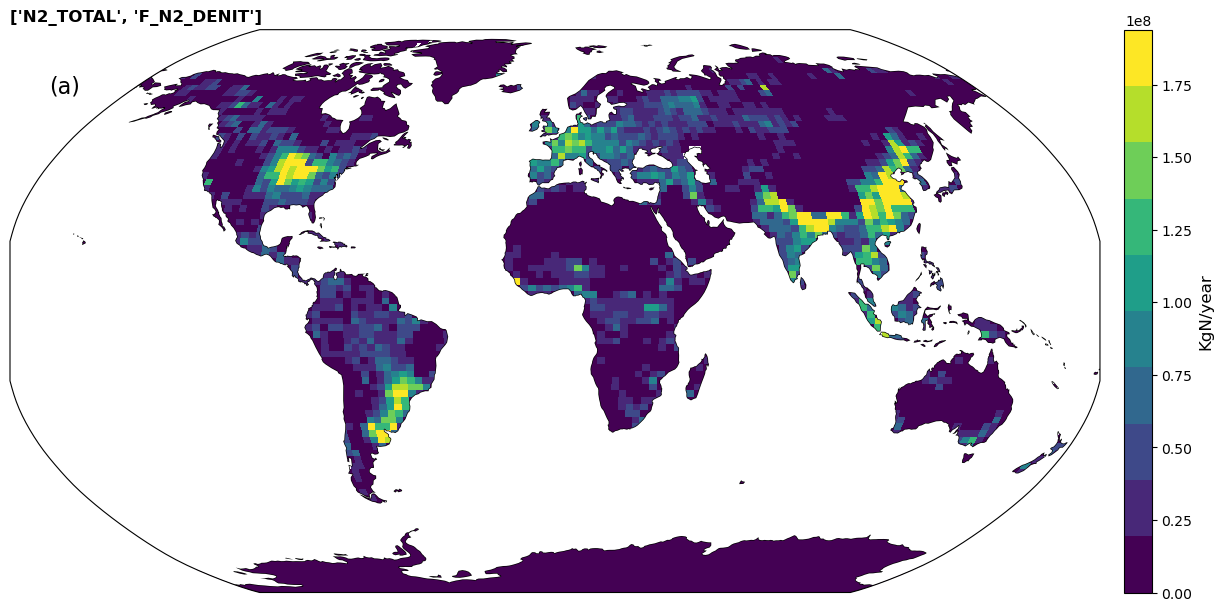

In [54]:
var=["N2_TOTAL", "F_N2_DENIT"]

if len(var) >1:
    for i, v in enumerate(var):
        if i == 0:
            plotData = dsCLM[v]
        else:
            plotData = plotData + dsCLM[v]
else:
    plotData = dsCLM[var[0]]
    
i = 0
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,6), constrained_layout=True, subplot_kw=dict(projection=ccrs.Robinson()))
for index, ax in np.ndenumerate(axes):
    if i == 0:
        plotData = plotData.mean(dim='time')
        plotData = plotData * dsCLM['area'].isel(time=0) *1e6* dsCLM['landfrac'].isel(time=0) * 365 * 24 * 3600 * 1e-3
        plotData.attrs['units'] = 'KgN/year'
        map_function(plotData, ax=ax, cb=2, panel='(a)', vmax=plotData.max(skipna=True).values * 0.5, 
                     title=var, vmin=0.0, nbins=10, units=plotData.attrs['units'])                  
    i = i+1

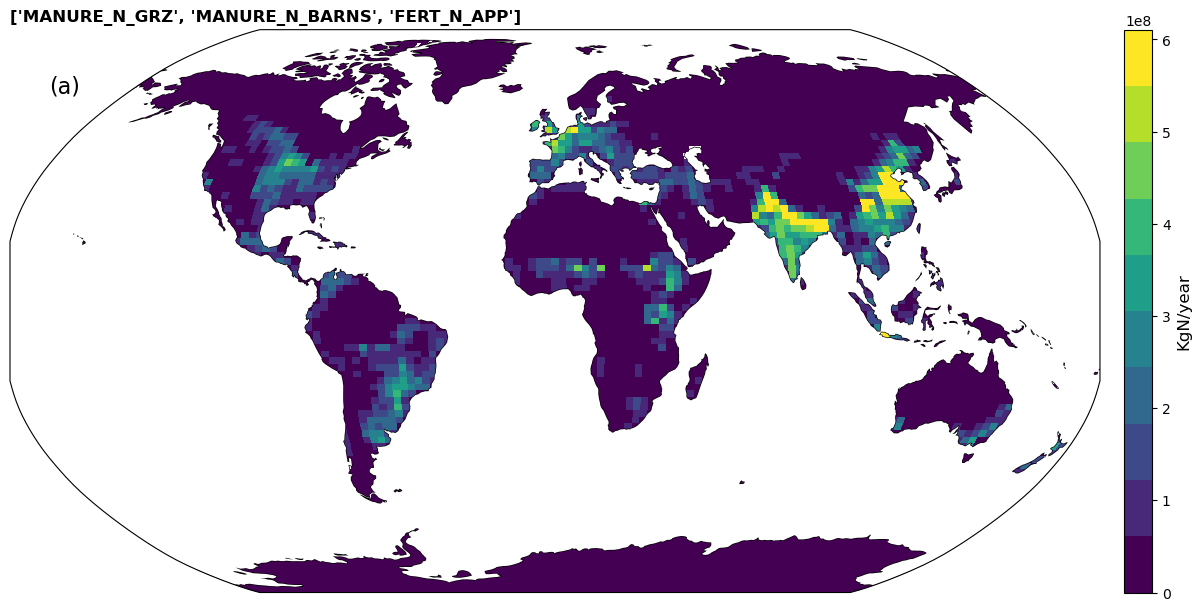

In [48]:
var=['MANURE_N_GRZ', 'MANURE_N_BARNS', 'FERT_N_APP']

if len(var) >1:
    for i, v in enumerate(var):
        if i == 0:
            plotData = dsCLM[v]
        else:
            plotData = plotData + dsCLM[v]
else:
    plotData = dsCLM[var[0]]
    
i = 0
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,6), constrained_layout=True, subplot_kw=dict(projection=ccrs.Robinson()))
for index, ax in np.ndenumerate(axes):
    if i == 0:
        plotData = plotData.mean(dim='time')
        plotData = plotData * dsCLM['area'].isel(time=0) *1e6* dsCLM['landfrac'].isel(time=0) * 365 * 24 * 3600 * 1e-3
        plotData.attrs['units'] = 'KgN/year'
        map_function(plotData, ax=ax, cb=2, panel='(a)', vmax=plotData.max(skipna=True).values * 0.5, 
                     title=var, vmin=0.0, nbins=10, units=plotData.attrs['units'])                  
    i = i+1

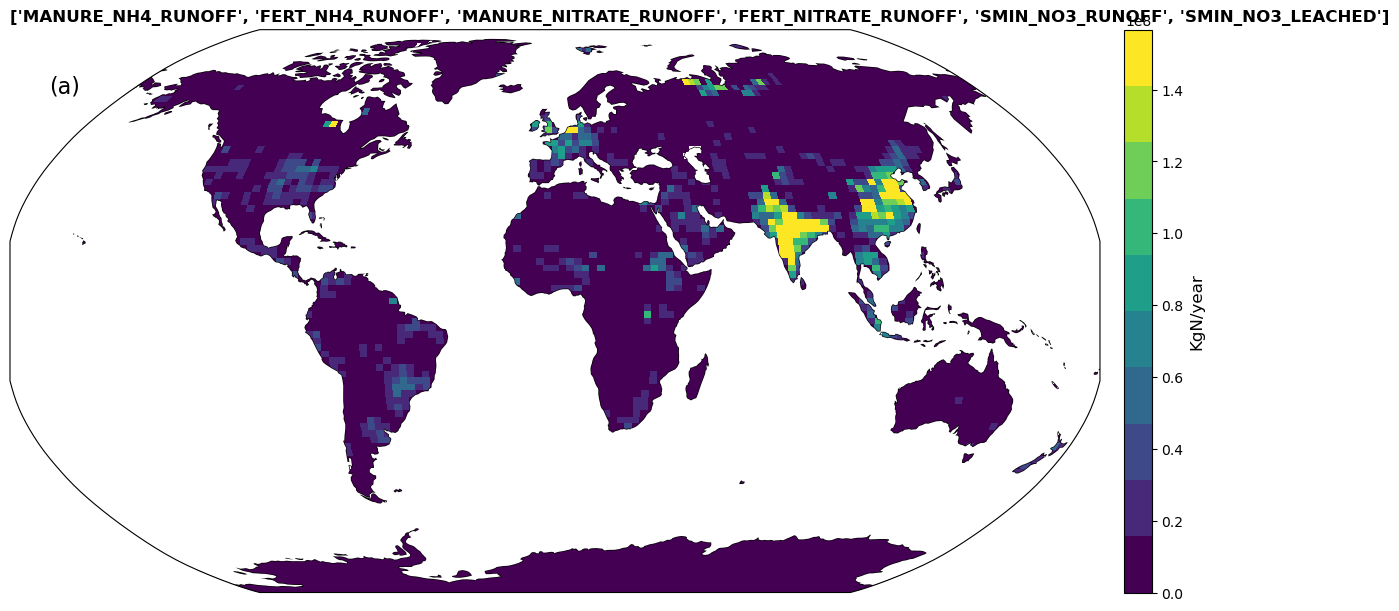

In [53]:
var=['MANURE_NH4_RUNOFF', 'FERT_NH4_RUNOFF', 'MANURE_NITRATE_RUNOFF', 'FERT_NITRATE_RUNOFF',
    'SMIN_NO3_RUNOFF', 'SMIN_NO3_LEACHED',]

if len(var) >1:
    for i, v in enumerate(var):
        if i == 0:
            plotData = dsCLM[v]
        else:
            plotData = plotData + dsCLM[v]
else:
    plotData = dsCLM[var[0]]
    
i = 0
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,6), constrained_layout=True, subplot_kw=dict(projection=ccrs.Robinson()))
for index, ax in np.ndenumerate(axes):
    if i == 0:
        plotData = plotData.mean(dim='time')
        plotData = plotData * dsCLM['area'].isel(time=0) *1e6* dsCLM['landfrac'].isel(time=0) * 365 * 24 * 3600 * 1e-3
        plotData.attrs['units'] = 'KgN/year'
        map_function(plotData, ax=ax, cb=2, panel='(a)', vmax=plotData.max(skipna=True).values * 0.5, 
                     title=var, vmin=0.0, nbins=10, units=plotData.attrs['units'])                  
    i = i+1

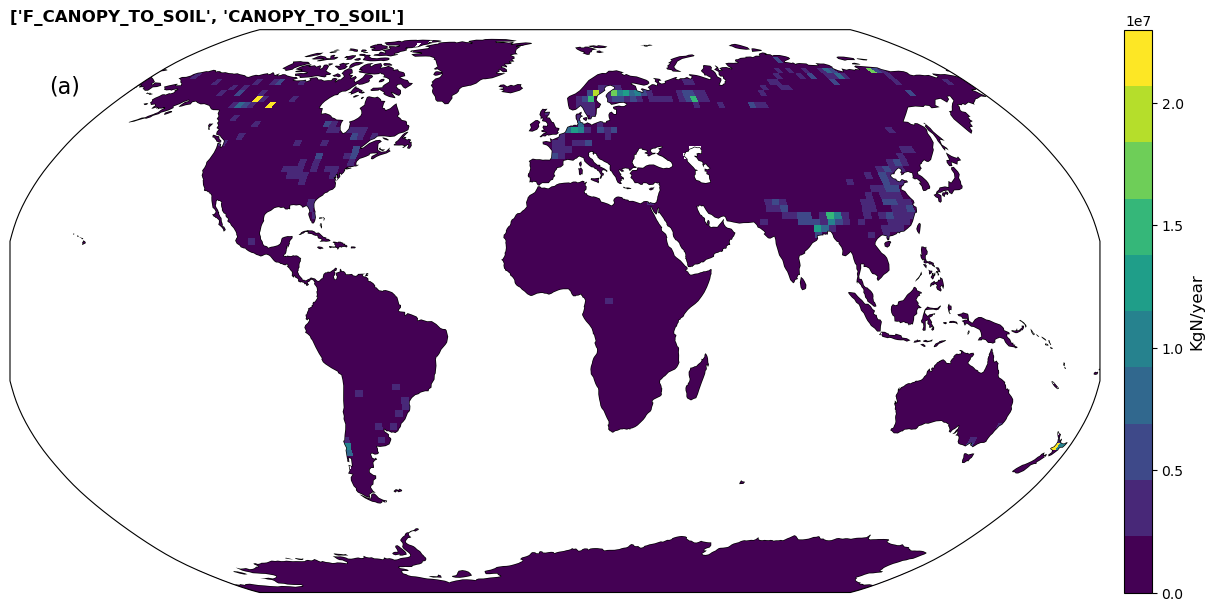

In [57]:
var=['F_CANOPY_TO_SOIL', 'CANOPY_TO_SOIL']

if len(var) >1:
    for i, v in enumerate(var):
        if i == 0:
            plotData = dsCLM[v]
        else:
            plotData = plotData + dsCLM[v]
else:
    plotData = dsCLM[var[0]]
    
i = 0
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,6), constrained_layout=True, subplot_kw=dict(projection=ccrs.Robinson()))
for index, ax in np.ndenumerate(axes):
    if i == 0:
        plotData = plotData.mean(dim='time')
        plotData = plotData * dsCLM['area'].isel(time=0) *1e6* dsCLM['landfrac'].isel(time=0) * 365 * 24 * 3600 * 1e-3
        plotData.attrs['units'] = 'KgN/year'
        map_function(plotData, ax=ax, cb=2, panel='(a)', vmax=plotData.max(skipna=True).values * 0.5, 
                     title=var, vmin=0.0, nbins=10, units=plotData.attrs['units'])                  
    i = i+1

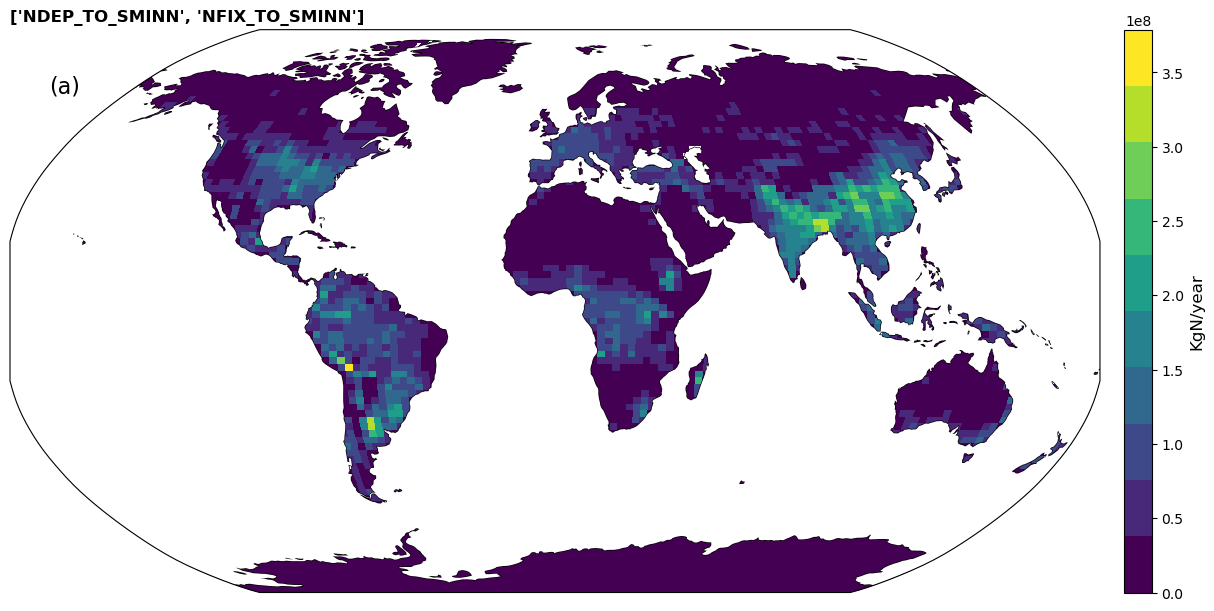

In [63]:
var=['NDEP_TO_SMINN', 'NFIX_TO_SMINN']

if len(var) >1:
    for i, v in enumerate(var):
        if i == 0:
            plotData = dsCLM[v]
        else:
            plotData = plotData + dsCLM[v]
else:
    plotData = dsCLM[var[0]]
    
i = 0
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,6), constrained_layout=True, subplot_kw=dict(projection=ccrs.Robinson()))
for index, ax in np.ndenumerate(axes):
    if i == 0:
        plotData = plotData.mean(dim='time')
        plotData = plotData * dsCLM['area'].isel(time=0) *1e6* dsCLM['landfrac'].isel(time=0) * 365 * 24 * 3600 * 1e-3
        plotData.attrs['units'] = 'KgN/year'
        map_function(plotData, ax=ax, cb=2, panel='(a)', vmax=plotData.max(skipna=True).values * 0.99, 
                     title=var, vmin=0.0, nbins=10, units=plotData.attrs['units'])                  
    i = i+1